**GMM first labaratory work.**<br>
Model - RasNet50<br>
Class - banana, bee, jellyfish

In [ ]:
!pip install openimages

In [ ]:
import torch
import torch.nn as nn
import os
from openimages.download import download_dataset
import torchvision
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

**Downloading the images and setting up the dataset**

In [ ]:
#Setting up the information about dataset
data_dir = "data"
number_for_samples = 333
classes = ['Banana', 'Bee', 'Jellyfish']

In [ ]:
# Load the pre-trained ResNet50 model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
preprocess = weights.transforms()
# Set the model to evaluation mode
model.eval()

In [ ]:
#Finding the indexes of used classes
classesForIndexes = ['banana', 'bee', 'jellyfish']
categories = weights.meta["categories"]
classesIndexes = [];
category_to_index = {category: index for index, category in enumerate(categories)}
for c in classesForIndexes:
  category_index = category_to_index[c]
  classesIndexes.append(category_index)

print(classesIndexes)

In [ ]:
#Making sure that the directory exists before proceding
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [ ]:
#Downloading the images from openimages dataset
print("Downloading is starting...")
download_dataset(data_dir, classes, limit=number_for_samples)

In [ ]:
#File transformation function
def read_img(file_name):
    img = io.imread(file_name)
    if img.ndim == 2:
      img = gray2rgb(img)
    #Resize to the standart 
    img = [resize(img, (224, 224))]
    img = torch.tensor(img)
    #Changing the positions of tensor
    img = img.permute(0, 3, 2, 1)
    img_transformed = preprocess(img)
    return img_transformed


In [ ]:
#Creating custom dataset
class CustomDataset(Dataset):
    def __init__(self, images_dir):
        #All images directory
        self.images_dir = images_dir
        #Getting images of specific class directories
        self.class1_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(classes[0].lower()))
        self.class2_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(classes[1].lower()))
        self.class3_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(classes[2].lower()))
        #Getting length of each class
        self.class1 = len(self.class1_files)
        self.class2 = len(self.class2_files)
        self.class3 = len(self.class3_files)
        #All dataset length
        self.files = self.class1_files + self.class2_files + self.class3_files
        #Assigning labels to each file
        self.labels = np.zeros(len(self.files), dtype=int)
        for i, file_path in enumerate(self.files):
            if file_path in self.class1_files:
                self.labels[i] = classesIndexes[0]
            elif file_path in self.class2_files:
                self.labels[i] = classesIndexes[1]
            else:
                self.labels[i] = classesIndexes[2]


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        #Getting files and transforming them
        files = self.files[i]
        im = read_img(files)[0]
        y = self.labels[i]
        return (im, y)
dataset = CustomDataset("./data")

In [ ]:
#Initializing dataloader
batch_size = 20
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

**Model prediction using sigmoid**

In [ ]:
#Treshold [0:1]
threshold = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.999]
#Initializing metrics for statistic calculation
true_possitive = [0,0,0,0,0,0,0]
false_possitive = [0,0,0,0,0,0,0]
true_negative = [0,0,0,0,0,0,0]
false_negative = [0,0,0,0,0,0,0]
#Loading data from dataloader
for data in dataloader:
  inputs, labels = data
  class_probs_batch = []
  #Getting model predictions  
  with torch.no_grad():
    output = model(inputs)
    probs = output.sigmoid()
  #Picking out predictions from batch 
  for i in range(probs.shape[0]):
    #Picking only predictions from selected classes
    class_probs_item = [probs[i, j] for j in classesIndexes] #print
    class_probs_batch.append(class_probs_item)
  #Iteration for Label id from batch
  x = 0
  for cpb in class_probs_batch:
    #Iteration for Class id from selected classes
    j = 0
    for cp in cpb:
      #Iteration for threshold measurments 
      i = 0
      for th in threshold:
        #A positive instance that is correctly classified as positive by the model
        if (classesIndexes[j] == labels[x]) and  (cp > th): 
            true_possitive[i] += 1
        #A negative instance that is incorrectly classified as positive by the model.
        elif (classesIndexes[j] == labels[x]) and (cp < th):
            false_negative[i] += 1
        #A positive instance that is incorrectly classified as negative by the model.
        elif (classesIndexes[j] != labels[x]) and (cp > th):
            false_possitive[i] += 1
        #A negative instance that is correctly classified as negative by the model.
        elif (classesIndexes[j] != labels[x]) and (cp < th):
            true_negative[i] += 1
        i+=1
      j+=1
    x+=1

**Checking the results**

In [ ]:
i = 0
while(i<7):
  print(f"tp: {true_possitive[i]}")
  print(f"fp: {false_possitive[i]}")
  print(f"tn: {true_negative[i]}")
  print(f"fn: {false_negative[i]}")
  print()
  i+=1

**Calculating statistics**

In [ ]:
precisions = []
recalls = []
accuracies = []
f1_scores = []



i = 0
for th in threshold:
  #Precision measures how many of the predicted positive labels are actually true positives
  precision = true_possitive[i] / (true_possitive[i] + false_possitive[i])
  #Recall measures how many of the actual positive labels are correctly identified
  recall = true_possitive[i] / (true_possitive[i] + false_negative[i])
  #Accuracy measures how well the model correctly predicts both positive and negative labels
  accuracy = (true_possitive[i] + true_negative[i]) / (true_possitive[i] + true_negative[i] + false_possitive[i] + false_negative[i]);
  #The F1 statistic is a measure of a model's accuracy, specifically in terms of its precision and recall.
  f1 = 2 * (precision * recall) / (precision + recall)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1: {f1}\n")

  precisions.append(precision)
  recalls.append(recall)
  accuracies.append(accuracy)
  f1_scores.append(f1)


  i+=1

**Diagrams**

In [ ]:
import matplotlib.pyplot as plt

Precision statistic

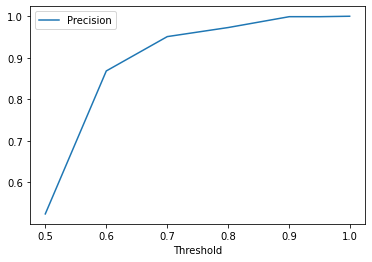

In [ ]:
plt.plot(threshold, precisions, label='Precision')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Recal statistic

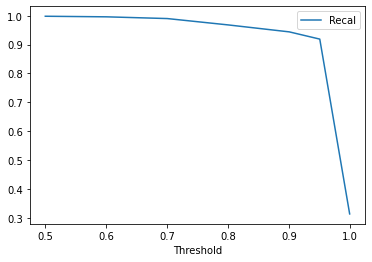

In [ ]:
plt.plot(threshold, recalls, label='Recal')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Accuracy statistic

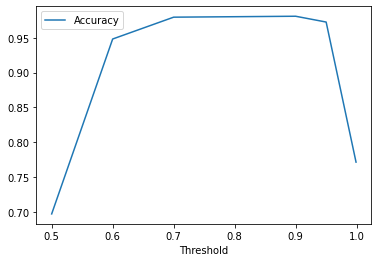

In [ ]:
plt.plot(threshold, accuracies, label='Accuracy')
plt.xlabel('Threshold')
plt.legend()
plt.show()

F1 statistic

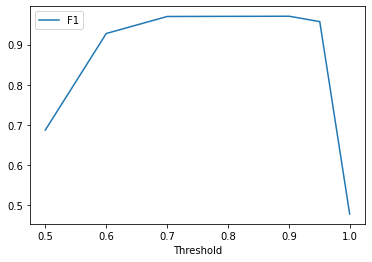

In [ ]:
plt.plot(threshold, f1_scores, label='F1')
plt.xlabel('Threshold')
plt.legend()
plt.show()

All statistics

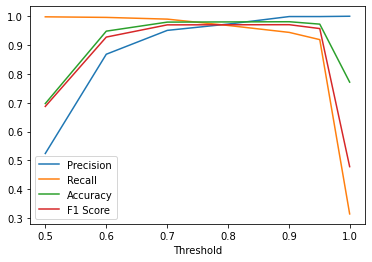

In [ ]:
plt.plot(threshold, precisions, label='Precision')
plt.plot(threshold, recalls, label='Recall')
plt.plot(threshold, accuracies, label='Accuracy')
plt.plot(threshold, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.legend()
plt.show()